In [1]:
using SIIPExamples #hide
using PowerSimulationsDynamics
using PowerSystems
using Sundials
using Plots
gr()
PSD = PowerSimulationsDynamics

PowerSimulationsDynamics

In [2]:
omib_sys = System("omib_sys.json")

┌ Warning: struct DynamicGenerator does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems C:\Users\ALIENWARE\.julia\packages\InfrastructureSystems\bCJWE\src\validation.jl:51
┌ Warning: struct DynamicGenerator does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems C:\Users\ALIENWARE\.julia\packages\InfrastructureSystems\bCJWE\src\validation.jl:51
┌ Warning: There are no ElectricLoad Components in the System
└ @ PowerSystems C:\Users\ALIENWARE\.julia\packages\PowerSystems\QT2dm\src\utils\IO\system_checks.jl:59


System
┌───────────────────┬─────────────┐
│ Property          │ Value       │
├───────────────────┼─────────────┤
│ System Units Base │ SYSTEM_BASE │
│ Base Power        │ 100.0       │
│ Base Frequency    │ 60.0        │
│ Num Components    │ 10          │
└───────────────────┴─────────────┘

Static Components
┌─────────────────┬───────┬────────────────────────┬───────────────┐
│ Type            │ Count │ Has Static Time Series │ Has Forecasts │
├─────────────────┼───────┼────────────────────────┼───────────────┤
│ Arc             │ 1     │ false                  │ false         │
│ Area            │ 1     │ false                  │ false         │
│ Bus             │ 2     │ false                  │ false         │
│ Line            │ 2     │ false                  │ false         │
│ LoadZone        │ 1     │ false                  │ false         │
│ Source          │ 1     │ false                  │ false         │
│ ThermalStandard │ 1     │ false                  │ false         │
└─────────────────┴───────┴────────────────────────┴───────────────┘

Dynamic Components
┌────────────────────────────────────────────────────────────────────────┬──────
│ Type                                                                   │ Cou ⋯
├────────────────────────────────────────────────────────────────────────┼──────
│ DynamicGenerator{BaseMachine, SingleMass, AVRFixed, TGFixed, PSSFixed} │ 1   ⋯
└────────────────────────────────────────────────────────────────────────┴──────
                                                                1 column omitted

In [3]:
time_span = (0.0, 30.0)
perturbation_trip = BranchTrip(4.0, Line, "BUS 1-BUS 2-i_1")
sim = PSD.Simulation(ResidualModel, omib_sys, pwd(), time_span, perturbation_trip)

base64 binary data: 0tG4tNbGICAgICAgICAgMSC49s7EvP6how0K


┌ Info: Unit System changed to UnitSystem.DEVICE_BASE = 1
└ @ PowerSystems C:\Users\ALIENWARE\.julia\packages\PowerSystems\QT2dm\src\base.jl:351


Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.619940e-07              NaN
     1     1.222489e-11     3.865749e-08


┌ Info: 
│  ───────────────────────────────────────────────────────────────────────────────
│                                                      Time          Allocations  
│                                                ───────────────   ───────────────
│                 Total measured:                     14.3s            1.69GiB    
│ 
│  Section                               ncalls     time    %tot     alloc    %tot
│  ───────────────────────────────────────────────────────────────────────────────
│  Build Simulation                           1    14.3s  100.0%   1.69GiB  100.0%
│    Build Simulation Inputs                  1    3.59s   25.1%    178MiB   10.3%
│      Wrap Branches                          1   81.7μs    0.0%   3.93KiB    0.0%
│      Wrap Dynamic Injectors                 1    1.19s    8.3%   97.5MiB    5.6%
│      Calculate MM, DAE_vector, Tota...      1   79.0ms    0.6%   7.38MiB    0.4%
│      Wrap Static Injectors                  1    100ms    0.7%   4.60MiB 

Property,Value
Simulation Type,Residual Model
Initialized?,Yes
Multimachine system?,No
Time Span,"(0.0, 30.0)"
Number of States,6
Number of Perturbations,1


In [4]:
show_states_initial_value(sim)

Voltage Variables
BUS 1
Vm 1.05
θ -0.0
BUS 2
Vm 1.04
θ 0.0229
Differential States
generator-102-1
δ 0.1685
ω 1.0


In [5]:
x0_init = PSD.get_initial_conditions(sim)

6-element Vector{Float64}:
  1.0500000000000593
  1.039727419637545
 -1.3318504893726944e-19
  0.02380952380952248
  0.16852476256464868
  1.0

In [6]:
PSD.execute!(
    sim, #simulation structure
    IDA(), #Sundials DAE Solver
    dtmax = 0.02,
); #Arguments: Maximum timestep allowed

In [7]:
results = read_results(sim)

Property,Value
System Base Power [MVA],100.0
System Base Frequency [Hz],60.0
Time Span,"(0.0, 30.0)"
Total Time Steps,1510
Number of States,6
Total solve time,25.3809249


In [8]:
typeof(results)

SimulationResults

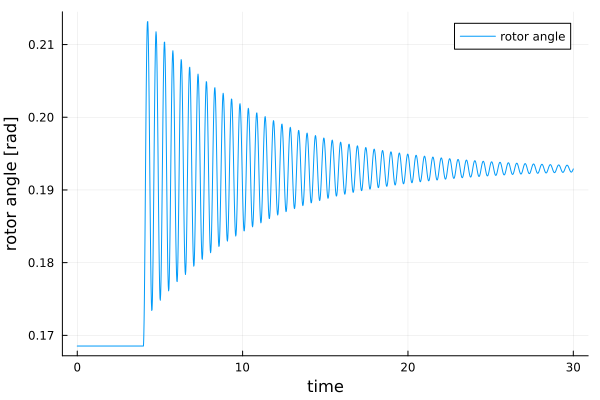

In [9]:
angle1 = get_state_series(results, ("generator-102-1", :δ));
plot(angle1, xlabel = "time", ylabel = "rotor angle [rad]", label = "rotor angle")

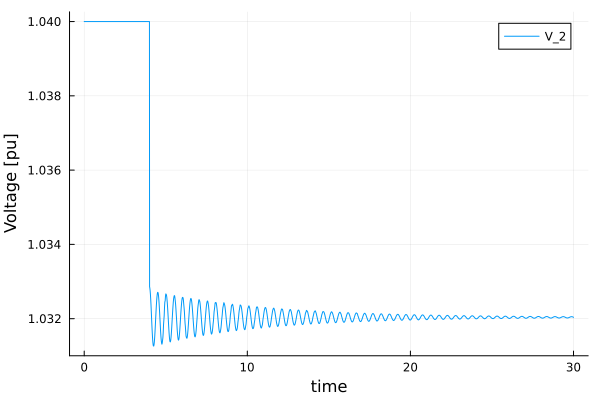

In [10]:
volt = get_voltage_magnitude_series(results, 102);
plot(volt, xlabel = "time", ylabel = "Voltage [pu]", label = "V_2")

In [11]:
sim2 = PSD.Simulation(ResidualModel, omib_sys, pwd(), time_span)

small_sig = small_signal_analysis(sim2)

base64 binary data: 0tG4tNbGICAgICAgICAgMSC49s7EvP6how0KSXRlciAgICAgZih4KSBpbmYtbm9ybSAgICBTdGVwIDItbm9ybSAKLS0tLS0tICAgLS0tLS0tLS0tLS0tLS0gICAtLS0tLS0tLS0tLS0tLQogICAgIDAgICAgIDUuNjE5OTQwZS0wNyAgICAgICAgICAgICAgTmFOCiAgICAgMSAgICAgMS4yMjI0ODllLTExICAgICAzLjg2NTc0OWUtMDgK


┌ Info: Unit System changed to UnitSystem.DEVICE_BASE = 1
└ @ PowerSystems C:\Users\ALIENWARE\.julia\packages\PowerSystems\QT2dm\src\base.jl:351
┌ Info: 
│  ───────────────────────────────────────────────────────────────────────────────
│                                                      Time          Allocations  
│                                                ───────────────   ───────────────
│                 Total measured:                    2.47ms             385KiB    
│ 
│  Section                               ncalls     time    %tot     alloc    %tot
│  ───────────────────────────────────────────────────────────────────────────────
│  Build Simulation                           1   2.47ms  100.0%    384KiB  100.0%
│    Build Simulation Inputs                  1    527μs   21.3%   89.3KiB   23.2%
│      Wrap Branches                          1   12.2μs    0.5%   3.93KiB    1.0%
│      Wrap Dynamic Injectors                 1    221μs    8.9%   29.6KiB    7.7%
│      Calcul

The system is small signal stable


In [12]:
small_sig.reduced_jacobian

2×2 Matrix{Float64}:
  0.0       376.991
 -0.466763   -0.317662

In [13]:
small_sig.eigenvalues

2-element Vector{ComplexF64}:
 -0.15883100381194412 - 13.264252860693972im
 -0.15883100381194412 + 13.264252860693972im